In [ ]:
from MyImports import *
from ModelTrainingUtils import plot_accuracy,plot_loss
from sklearn.metrics import confusion_matrix, classification_report
from ModelUtils import classwise_accuracy,process_image,predict_image_class

In [5]:
train_path = Path('./images/train')
test_path = Path('./images/test')

In [6]:
# Resize train data and split the data for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       validation_split = 0.2,
                                                       subset = "training",
                                                       shuffle=True)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       validation_split = 0.2,
                                                       subset = "validation")

Found 3135 files belonging to 4 classes.
Using 627 files for validation.


In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = image_size,
                                                       seed = 2022,
                                                       shuffle = False
                                                      )

Found 351 files belonging to 4 classes.


In [27]:
class_names = test_ds.class_names  # list of class names

In [13]:
#Data Augmentation
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2)
])

aug_ds = train_ds

for image, label in aug_ds :
  image = augmentation(image)

In [9]:
model_CNN = tf.keras.Sequential([

tf.keras.layers.InputLayer(input_shape = [image_size[0], image_size[1], 3]),
tf.keras.layers.Rescaling(1./255),


tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.MaxPool2D(pool_size = (2,2)),

tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
tf.keras.layers.MaxPool2D(pool_size = (2,2)),

tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'),

tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(4, activation = 'softmax')
])

In [11]:
model_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', 'Precision', 'Recall'])

In [16]:
log_dir = "./logs/CNNN"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 3, restore_best_weights=True
)

In [17]:
history_CNN = model_CNN.fit(aug_ds, validation_data = valid_ds, epochs = 25, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/25


79/79 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - Precision: 0.8296 - Recall: 0.3327 - accuracy: 0.6298 - loss: 0.9505 - val_Precision: 0.7980 - val_Recall: 0.5040 - val_accuracy: 0.6922 - val_loss: 0.7624
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - Precision: 0.7973 - Recall: 0.5787 - accuracy: 0.7078 - loss: 0.7240 - val_Precision: 0.8133 - val_Recall: 0.6045 - val_accuracy: 0.7209 - val_loss: 0.6929
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - Precision: 0.8091 - Recall: 0.6324 - accuracy: 0.7300 - loss: 0.6715 - val_Precision: 0.8257 - val_Recall: 0.6348 - val_accuracy: 0.7241 - val_loss: 0.6927
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - Precision: 0.8197 - Recall: 0.6759 - accuracy: 0.7570 - loss: 0.6382 - val_Precision: 0.8115 - val_Recall: 0.6523 - val_accuracy: 0.7305 - val_loss: 0.6582
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - Precision: 0.8121 - Recall: 0.6855 - accuracy: 0.7620 - loss: 0.6207 - val_Precision: 0.8369 - val_Recall: 0.6794 - val_ac

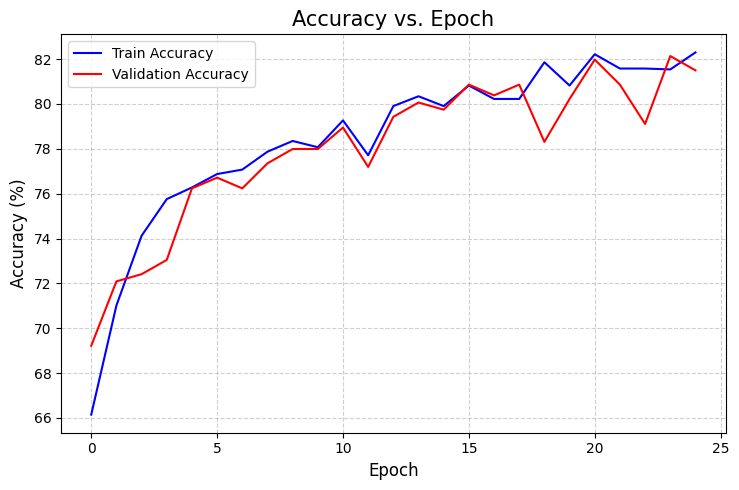

In [20]:
plot_accuracy(history_CNN)

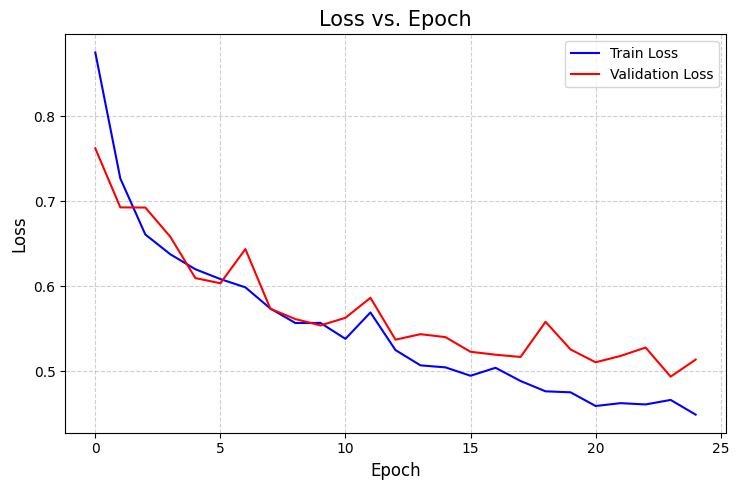

In [22]:
plot_loss(history_CNN)

In [35]:
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
if y_true.ndim > 1:  # one-hot or multi-label
    y_true = y_true.argmax(axis=1)  # convert one-hot to integer labels


In [36]:
#y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_pred_probs = model_CNN.predict(test_ds)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step


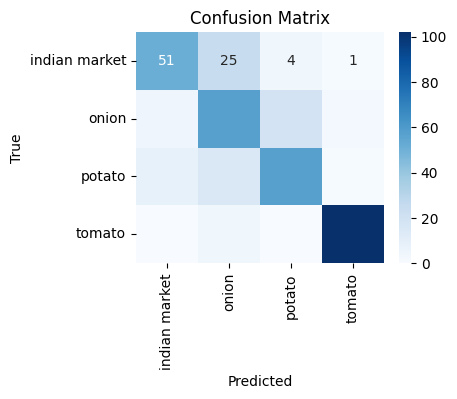

               precision    recall  f1-score   support

indian market       0.80      0.63      0.70        81
        onion       0.56      0.69      0.62        83
       potato       0.71      0.70      0.71        81
       tomato       0.96      0.96      0.96       106

     accuracy                           0.76       351
    macro avg       0.76      0.75      0.75       351
 weighted avg       0.77      0.76      0.76       351



In [44]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [23]:
model_CNN.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - Precision: 0.7689 - Recall: 0.7058 - accuracy: 0.7501 - loss: 0.5407


[0.5218650698661804,
 0.7606837749481201,
 0.7863777279853821,
 0.7236467003822327]

In [ ]:
"""
| Metric    | Train  | Validation | Test   |
| --------- | ------ | ---------- | ------ |
| Accuracy  | 81.63% | 82.14%     | 75.01% |
| Precision | 85.14% | 87.48%     | 76.89% |
| Recall    | 77.21% | 77.99%     | 70.58% |
| Loss      | 0.4600 | 0.4935     | 0.5407 |

"""